# Setup

In [87]:
from pathlib import Path

import matplotlib.pyplot as plt
import tiktoken
import torch
from matplotlib.ticker import MaxNLocator
from torch import nn

from src.build_llm_from_scratch_book.dataloader import create_data_loader_v1
from src.build_llm_from_scratch_book.loss import calculate_loss_batch, calculate_loss_loader
from src.build_llm_from_scratch_book.modules import (
    GPTConfig,
    GPTModel,
)
from src.build_llm_from_scratch_book.text import generate_text_simple, text_to_token_ids, token_ids_to_text

In [88]:
config = GPTConfig(
    vocab_size=50257, context_length=256, embed_dim=768, n_heads=12, n_layers=12, drop_rate=0.1, qkv_bias=False
)
torch.manual_seed(123)
model = GPTModel(config)
model.eval()

GPTModel(
  (token_embeddings): Embedding(50257, 768)
  (positional_embeddings): Embedding(256, 768)
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
       

# Generate text

Generate text with untrained model. 10 tokens are, generated, all giberrish


In [89]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=config.context_length,
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic chief refusing holidays Shannon GamergateHay men methamphetamine


# Evaluate loss between preds and expected outputs (targets)

Simulate predictions accross 2 input vectors

In [90]:
inputs = torch.tensor(
    [
        [16833, 3626, 6100],  # ["every", "effort" "moves"],
        [40, 1107, 588],  # ["I", "really", "like"]
    ]
)

In [91]:
targets = torch.tensor(
    [
        [3626, 6100, 345],  # ["effort", "moves", "you",
        [1107, 588, 11311],  # ["really", "like", "chocolate"]
    ]
)

In [92]:
with torch.no_grad():
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1)
probas.shape  # batch_size, seq_len (number of tokens), vocab_size

torch.Size([2, 3, 50257])

In [93]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)
print(token_ids.shape)  # shows the last dimension has been reduced to 1 (the token ids)

Token IDs:
 tensor([[[50153],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])
torch.Size([2, 3, 1])


Running this shows that the generated text does not match the target (expected output)

In [94]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1:" f" {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  PRESIDENT heNetflix


Initial probabilties

In [95]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.6198e-05, 3.1919e-05, 1.1728e-05])
Text 2: tensor([1.0538e-05, 5.5378e-05, 4.9063e-06])


## Calculate (cross entropy) loss for the proba scores of the two batches relatives to their targets (expected values)

### Understanding torch.log()

In this code, `torch.log()` is used to calculate the natural logarithm (log base e) of the probability values. This is a crucial step in calculating the loss function for training the language model. Here's why:

1. **Natural Logarithm**: `torch.log()` computes the natural logarithm of each element in the input tensor. For a probability p, it returns ln(p).

2. **Why Use Log Probabilities**:
   - Working with log probabilities is numerically more stable than raw probabilities
   - When probabilities are very small (like in our case, ranging from ~10^-5 to ~10^-12), their log values are more manageable
   - Log probabilities can be added instead of multiplying probabilities, which helps prevent numerical underflow

3. **In Our Code**:
   - We first calculate probabilities using softmax: `probas = torch.softmax(logits, dim=-1)`
   - Then we take the log of these probabilities: `log_probas = torch.log(...)`
   - The negative of these log probabilities will be used to compute the cross-entropy loss

4. **Example**:
   - If a probability is 0.0001 (1e-4)
   - Its log value would be approximately -9.21
   - This is why we see negative values in our output tensor (like -9.4822, -10.3523, etc.)

This transformation is a standard step in training neural networks for classification tasks, particularly in language modeling where we need to handle many small probability values.

In [96]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.4822, -10.3523, -11.3535, -11.4605,  -9.8013, -12.2250])


## Compute the average of the log probabilities

In [97]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7791)


The goal is to get the average log probability as close to 0 as possible by updating the model’s weights as part of the training process. However, in deep learning, the common practice isn’t to push the average log probability up to 0 but rather to bring the negative average log probability down to 0. The negative average log probability is simply the average log probability multiplied by –1. 

This is the cross-entropy loss.



In [98]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7791)


### Computing cross entropy with pytorch

Let's remind ourself of the dimensions of the predicted logits and targets

In [99]:
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


The shape don't match, so the tensors need flattening

In [100]:
logits_flat = logits.flatten(0, 1)  # combines the dimensions 0 and 1 -> the batches disappear, we have only tokens
targets_flat = targets.flatten()
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


Once flattened, we can apply cross-entropy loss and we see the results are the same as the manual step

In [101]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
loss

tensor(10.7791)

# Training and validation set losses

## Calculating losses

Load the short story to train LLM

In [102]:
file_path = "the-verdict.txt"
with Path(file_path).open("r", encoding="utf-8") as file:
    text_data = file.read()

Printing some stats about the dataset

In [103]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


To implement the data splitting and loading, we first define a train_ratio to use 90% of the data for training and the remaining 10% as validation data for model evaluation during training

In [104]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [105]:
torch.manual_seed(123)

train_loader = create_data_loader_v1(
    train_data,
    batch_size=2,
    context_window_size=config.context_length,
    stride=config.context_length,
    drop_last=True,
    shuffle=True,
    num_workers=0,
)
val_loader = create_data_loader_v1(
    val_data,
    batch_size=2,
    context_window_size=config.context_length,
    stride=config.context_length,
    drop_last=False,
    shuffle=False,
    num_workers=0,
)

Iterate over the data loaders to make sure they are loaded correctly

In [106]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


Now we can calculate loss with loaders

In [107]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad():
    train_loss = calculate_loss_loader(train_loader, model, device)
    val_loss = calculate_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.990696377224392
Validation loss: 10.985530853271484


## Training code

In [108]:
def evaluate_model(
    model: nn.Module,
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    device: torch.device,
    eval_iter: int,
) -> tuple[float, float]:
    """Evaluate the model."""
    model.eval()
    with torch.no_grad():
        train_loss = calculate_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calculate_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [109]:
def generate_and_print_sample(
    model: nn.Module, tokenizer: tiktoken.Encoding, device: torch.device, start_context: int
) -> None:
    """Generate and print sample."""
    model.eval()
    context_size = model.positional_embeddings.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(model=model, idx=encoded, max_new_tokens=50, context_size=context_size)
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

In [110]:
def train_model_simple(  # noqa: PLR0913
    model: nn.Module,
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    optimizer: torch.optim.AdamW,
    device: torch.device,
    num_epochs: int,
    eval_freq: int,
    eval_iter: int,
    start_context: str,
    tokenizer: tiktoken.Encoding,
) -> tuple[list[float], list[float], list[int]]:
    """Train the model."""
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calculate_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(
                    f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {train_loss:.3f}, "
                    f"Val loss {val_loss:.3f}"
                )
        generate_and_print_sample(model, tokenizer, device, start_context)
    return train_losses, val_losses, track_tokens_seen

Let's run a training session

In [111]:
torch.manual_seed(123)
model = GPTModel(cfg=config)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
# num_epochs = 10
num_epochs = 1

train_losses, val_losses, tokens_seen = train_model_simple(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context="Every effort moves you",
    tokenizer=tokenizer,
)

Ep 1 (Step 000000): Train loss 9.820, Val loss 9.962
Ep 1 (Step 000005): Train loss 7.963, Val loss 8.282
Every effort moves you the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


## Plotting losses

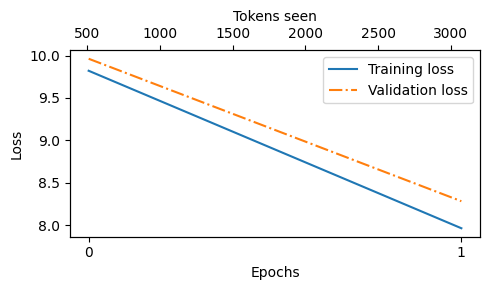

In [112]:
def plot_losses(
    epochs_seen: torch.Tensor, tokens_seen: list[int], train_losses: list[float], val_losses: list[float]
) -> None:
    """Plot the losses."""
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()


epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

# Decoding strategies / randomness

In [113]:
model.to("cpu")
model.eval()

GPTModel(
  (token_embeddings): Embedding(50257, 768)
  (positional_embeddings): Embedding(256, 768)
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
       

Plugin GPTModel instance into generate_text_simple func. We can run this multiple times and since the probas do not change,
the same output text is generated every time.

In [114]:
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=config.context_length,
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you the the the the the the the the the the the the the the the the the the the the the the the the the


# Temperature scaling

In [115]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}
inverse_vocab = {v: k for k, v in vocab.items()}

In [116]:
next_token_logits = torch.tensor([4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79])

In [117]:
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward


Replacing argmax (that selects the item with highest proba) with multinomial (selects from distribution of highest probas).
This leads to more variety in produced results.

In [118]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


To illustrate this is indeed selecting, let's repeat the operation 1000 times

In [119]:
def print_sampled_tokens(probas) -> None:
    """Select amongst probas, 1000 times to illustrate temperature."""
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")


print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward


In [120]:
def softmax_with_temperature(logits: torch.Tensor, temperature: float) -> torch.Tensor:
    """Softmax with temp."""
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

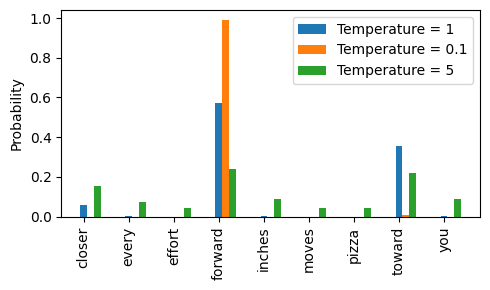

In [121]:
temperatures = [1, 0.1, 5]
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f"Temperature = {T}")
ax.set_ylabel("Probability")
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

# Top-k sampling

In [122]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [123]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float('-inf')),
    other=next_token_logits
)
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])
